In [29]:
import pandas as pd
pd.__version__

'0.23.0'

### Data Loading

Load all the data from the input files into a single data frame

In [50]:
dfList = []
for i in range(1,32):
    dfList.append(pd.read_json("./data/return-data/2017-01-{0:02d}.txt".format(i), lines=True))
df = pd.concat(dfList)

In [51]:
print(df.returnLabel.value_counts())
df.head()

0    30051
1      949
Name: returnLabel, dtype: int64


,basket,returnLabel,totalAmount,transactionId,zipCode
0,"[1, 2, 0, 2, 0, 3, 4]",0,672,9459085170,5574
1,"[2, 0, 4, 0, 4, 3]",0,354,3040906597,6413
2,"[5, 1, 1, 5]",0,232,7244223686,4106
3,"[4, 4, 3, 4, 5, 1]",0,462,9797154709,9614
4,"[5, 4, 4, 5]",0,48,5583717848,7148


### Feature Engineering

We transform the basket into an vector which has the count of the individual categories as values

In [52]:
df['c_0'] = df.basket.map(lambda x: x.count(0))
df['c_1'] = df.basket.map(lambda x: x.count(1))
df['c_2'] = df.basket.map(lambda x: x.count(2))
df['c_3'] = df.basket.map(lambda x: x.count(3))
df['c_4'] = df.basket.map(lambda x: x.count(4))
df['c_5'] = df.basket.map(lambda x: x.count(5))

In [53]:
df.head()

,basket,returnLabel,totalAmount,transactionId,zipCode,c_0,c_1,c_2,c_3,c_4,c_5
0,"[1, 2, 0, 2, 0, 3, 4]",0,672,9459085170,5574,2,1,2,1,1,0
1,"[2, 0, 4, 0, 4, 3]",0,354,3040906597,6413,2,0,1,1,2,0
2,"[5, 1, 1, 5]",0,232,7244223686,4106,0,2,0,0,0,2
3,"[4, 4, 3, 4, 5, 1]",0,462,9797154709,9614,0,1,0,1,3,1
4,"[5, 4, 4, 5]",0,48,5583717848,7148,0,0,0,0,2,2


For creating the one-hot encoded version of the `zipCode`, we define the dimension of the feature explicitely before we apply the `get_dummies` method. The reason is that we cannot be sure to have seen every possible value of `zipCode` in the training data, but we still need to create a feature for every possible value. Otherwise we would be in trouble in the later prediction phase, if there comes `zipCode` we have not seen during training. 

In [54]:
from pandas.api.types import CategoricalDtype
df["zipCode"] = df["zipCode"].astype('category', CategoricalDtype(categories=list(range(1000,10000))))
dummies = pd.get_dummies(df.zipCode)

In [55]:
df2 = pd.concat([df, dummies], axis=1)

In [56]:
df3 = df2.drop(["basket", "zipCode", "transactionId"], axis=1)

In [57]:
df3.head()

,returnLabel,totalAmount,c_0,c_1,c_2,c_3,c_4,c_5,1000,1001,...,18120,18197,18222,18331,18455,18567,18769,18989,19187,19873
0,0,672,2,1,2,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,354,2,0,1,1,2,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,232,0,2,0,0,0,2,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,462,0,1,0,1,3,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,48,0,0,0,0,2,2,0,0,...,0,0,0,0,0,0,0,0,0,0


### Model training

In [38]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(df3, test_size=0.3, random_state=0)
# save data to csv
train.to_pickle("./data/train.pickle")
test.to_pickle("./data/test.pickle")
train.head()

,returnLabel,totalAmount,c_0,c_1,c_2,c_3,c_4,c_5,1000,1001,...,18120,18197,18222,18331,18455,18567,18769,18989,19187,19873
281,0,124,0,0,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
57,0,51,0,0,0,2,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
273,0,216,0,3,2,1,2,1,0,0,...,0,0,0,0,0,0,0,0,0,0
725,0,75,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
55,0,87,0,0,0,0,0,3,0,0,...,0,0,0,0,0,0,0,0,0,0


In [69]:
X_train = train.drop(columns="returnLabel")
y_train = train["returnLabel"]
X_test = test.drop(columns="returnLabel")
y_test = test["returnLabel"]
X_train.shape

(21700, 8751)

In [70]:
X_train.head()

,totalAmount,c_0,c_1,c_2,c_3,c_4,c_5,1000,1001,1002,...,18120,18197,18222,18331,18455,18567,18769,18989,19187,19873
281,124,0,0,1,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
57,51,0,0,0,2,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
273,216,0,3,2,1,2,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
725,75,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
55,87,0,0,0,0,0,3,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [71]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [72]:
from sklearn.ensemble import GradientBoostingClassifier
gbt = GradientBoostingClassifier()
gbt.fit(X_train, y_train)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False)

### Model evaluation

Let's check the accuracy

In [73]:
test_scores_reg = logreg.predict(X_test)
test_scores_gbt = gbt.predict(X_test)

In [74]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test, test_scores_reg)

0.9787096774193549

In [75]:
accuracy_score(y_test, test_scores_gbt)

0.9760215053763441

Let's check the roc curves

In [76]:
test_scores_reg = logreg.predict_proba(X_test)
test_scores_gbt = gbt.predict_proba(X_test)

In [77]:
from sklearn.metrics import auc
from sklearn.metrics import roc_curve
fpr_reg, tpr_reg, _ =  roc_curve(y_test, test_scores_reg[:,1])
auc_reg = auc(fpr_reg, tpr_reg)
fpr_gbt, tpr_gbt, _ =  roc_curve(y_test, test_scores_gbt[:,1])
auc_gbt = auc(fpr_gbt, tpr_gbt)

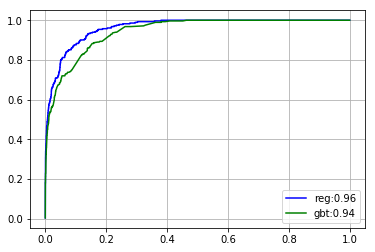

In [78]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.figure()
plt.plot(fpr_reg, tpr_reg, color = 'blue', label = "reg:{:.2f}".format(auc_reg))
plt.plot(fpr_gbt, tpr_gbt, color = 'green', label = "gbt:{:.2f}".format(auc_gbt))
plt.legend()
plt.grid()
plt.show()

### Save predictions on test and train data for modelCalibration

In [79]:
# save test predictions to csv
df = pd.DataFrame(data={'label': y_test, 'predReg': test_scores_reg[:,1], 
                  'predGbt': test_scores_gbt[:,1] })
df.to_csv("./data/predictions.csv", index=False)

# save test predictions to csv
train_scores_reg = logreg.predict_proba(X_train)
train_scores_gbt = gbt.predict_proba(X_train)
df = pd.DataFrame(data={'label': y_train, 'predReg': train_scores_reg[:,1], 
                  'predGbt': train_scores_gbt[:,1] })
df.to_csv("./data/predictions_train.csv", index=False)